In [61]:
import sklearn
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN
import csv
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn import preprocessing
import random

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.naive_bayes import GaussianNB

from sklearn.linear_model import Perceptron

from sklearn import tree

In [62]:
def mean(numbers):
    return np.mean(numbers, axis = 0)

# Calculate the standard deviation of a list of numbers
def stdev(numbers):
#     avg = mean(numbers)
#     variance = sum([(x-avg)**2 for x in numbers]) / float(len(numbers)-1)
#     return math.sqrt(variance)
    numbers = np.std(numbers, axis=0)
    return numbers

In [63]:
#deal with data set
def load(csv):
    train_set = np.genfromtxt(csv, delimiter = ",")
    # print("The col is " + str(len(train_set[0,:])))
    # print(len(test_set))

    train_list = train_set[:, 3:]
    class_list = train_set[:, 1]
    id_list = train_set[:, 2]

    train_data = np.column_stack((train_list, class_list))

    # print(np.shape(train_data))

    train_data = train_data.tolist()
    del(train_data[0])

    class_data = class_list.tolist()
    del(class_data[0])
    # print(len(class_data))

    id_data = id_list.tolist()
    del(id_data[0])

    return train_data, class_data, id_data

In [64]:
#process one data point into 13 features and class index
def feature_extraction(train_list):
    x_fea = []
    y_fea = []
    z_fea = []

    #delete class number
    mynewlist = [s for s in train_list if not math.isnan(s)]
    del(mynewlist[-1])

    # get rid of null data points
    for i in range(len(mynewlist)):  
        if i%3 == 0:
            x_fea.append(mynewlist[i])
        if i%3 == 1:
            y_fea.append(mynewlist[i])
        if i%3 == 2:
            z_fea.append(mynewlist[i])
            
    #one data point's 13 features
    length = (int)((len(mynewlist))/3)   
    x_mean, y_mean, z_mean = mean(x_fea), mean(y_fea), mean(z_fea)
    x_std, y_std, z_std = stdev(x_fea), stdev(y_fea), stdev(z_fea)
    min_x, min_y, min_z = min(x_fea), min(y_fea), min(z_fea)
    max_x, max_y, max_z = max(x_fea), max(y_fea), max(z_fea)

    return x_mean, y_mean, z_mean, x_std, y_std, z_std, min_x, min_y, min_z, max_x, max_y, max_z, length

    
#index classification
def idx_clf(id_list):
    total_index = []
    i_0 = id_list[0]
    tmp_list = []
    tmp_list.append(0)
    for i in range(1,len(id_list)):
        if id_list[i] != i_0:
            total_index.append(tmp_list)
            tmp_list = []
        tmp_list.append(i)
        i_0 = id_list[i]

    total_index.append(tmp_list)
    return total_index
   

In [65]:
def getResult(csv):
    train_data, class_data, id_data = load(csv)
    
    #length, x_mean, y_mean, z_mean, x_std, y_std, z_std, min_x, min_y, min_z, max_x, max_y, max_z, class_index
    features_data_points = []
    
    for li in train_data:
        tmp_list = []
        x_mean, y_mean, z_mean, x_std, y_std, z_std, min_x, min_y, min_z, max_x, max_y, max_z, length = feature_extraction(li)
        tmp_list.append(length)
        tmp_list.append(x_mean)
        tmp_list.append(y_mean)
        tmp_list.append(z_mean)
        tmp_list.append(x_std)
        tmp_list.append(y_std)
        tmp_list.append(z_std)
        tmp_list.append(min_x)
        tmp_list.append(min_y)
        tmp_list.append(min_z)
        tmp_list.append(max_x)
        tmp_list.append(max_y)
        tmp_list.append(max_z)
        
        
#         tmp_list.append((int)(class_data[index]))
        features_data_points.append(tmp_list)

    # M1_standardrazation
    features_data_points1 = preprocessing.scale(features_data_points)

    final_arr = features_data_points1.tolist()

    index = 0
    for li in final_arr:
        li.append((int)(class_data[index]))
        index += 1    
    
    total_index = idx_clf(id_data)   
    return final_arr, total_index

# # call function 
features_data_points, total_index = getResult("D_train.csv")
# print(features_data_points[0])
# # print(total_index[3])

In [66]:
def feature_selection(train_set, test_set):
        
    train_feature = [i[0:13] for i in train_set]
    train_label = [i[-1] for i in train_set]
    test_feature = [i[0:13] for i in test_set]
    test_label = [i[-1] for i in test_set]
    
    ##PCA
#     pca = PCA(n_components=13)
#     pca.fit(train_feature)
#     train_feature = pca.transform(train_feature)
#     test_feature = pca.transform(test_feature)

    ## selectkbest
    model = SelectKBest(k=8).fit(train_feature, train_label)
    train_feature = model.transform(train_feature)
    test_feature = model.transform(test_feature)
    
    return train_feature, train_label, test_feature, test_label

def labeled_dataset(train_feature, train_label, test_feature, test_label):
    train_data = np.column_stack((train_feature, train_label))
    test_data = np.column_stack((test_feature, test_label))
    return train_data, test_data

    
#split into k
def cross_split(dataset, folds):
    dataset_split = list()
    dataset_copy = list(dataset)

    for i in range(len(folds)):
        fold = list()
        for index in folds[i]:
            fold.append(dataset_copy[index])
        dataset_split.append(fold)
    return dataset_split

In [67]:
def evaluate_algorithm(dataset, algorithms, folds, *args):
    scores_crossvalidation = [[] for _ in range(7)]
    scores_training = [[] for _ in range(7)]
    
    datadset_split = cross_split(dataset, folds)
    for fold in datadset_split:
        for i in range(len(algorithms)):
            
            algorithm = algorithms[i]
            train_set = list(datadset_split)
            test_set = fold
            train_set.remove(fold)
            train_set = sum(train_set, [])
            accuracy, training_score = algorithm(train_set, test_set)
            scores_training[i].append(training_score)
            scores_crossvalidation[i].append(accuracy)
    return scores_crossvalidation, scores_training

In [68]:
def SVC_model(train_set, test_set):
    train_feature, train_label, test_feature, test_label = feature_selection(train_set, test_set)
    model = SVC(C=1, gamma = 'auto', kernel='rbf')
    model.fit(train_feature, train_label)
    training_score = model.score(train_feature, train_label)
    acc = model.score(test_feature, test_label)
    return acc, training_score

# scores = evaluate_algorithm(features_data_points, SVC_model, total_index)
# print(np.mean(scores, axis = 0))

In [69]:
def KNN_modell(train_set, test_set):
    train_feature, train_label, test_feature, test_label = feature_selection(train_set, test_set)    
    classifier = KNeighborsClassifier(n_neighbors=4)
    classifier.fit(train_feature, train_label)
#     predicted = classifier.predict(test_feature)
#     accuracy = accuracy_metric(test_set, predicted)
    training_score = classifier.score(train_feature, train_label)
    accuracy = classifier.score(test_feature, test_label)
    return accuracy, training_score
    
# scores = evaluate_algorithm(features_data_points, KNN_modell, total_index)
# print(np.mean(scores, axis = 0))

In [70]:
def log_regression(train_set, test_set):
    train_feature, train_label, test_feature, test_label = feature_selection(train_set, test_set)
    logreg = LogisticRegression()
    logreg.fit(train_feature, train_label)
    training_score = logreg.score(train_feature, train_label)
    accuracy = logreg.score(test_feature, test_label)
    return accuracy, training_score
    
# scores = evaluate_algorithm(features_data_points, log_regression, total_index)
# print(np.mean(scores, axis = 0))

In [71]:
def linear_discriminant(train_set, test_set):
    train_feature, train_label, test_feature, test_label = feature_selection(train_set, test_set)
    lda = LinearDiscriminantAnalysis()
    lda.fit(train_feature, train_label)
    training_score = lda.score(train_feature, train_label)
    accuracy = lda.score(test_feature, test_label)
    return accuracy, training_score

# scores = evaluate_algorithm(features_data_points, linear_discriminant, total_index)
# print(np.mean(scores, axis = 0))

In [72]:
def naive_bayes(train_set, test_set):
    train_feature, train_label, test_feature, test_label = feature_selection(train_set, test_set)
    gnb = GaussianNB()
    

    y_pred = gnb.fit(train_feature, train_label).predict(test_feature)

    training_score = gnb.score(train_feature, train_label)
    accuracy = gnb.score(test_feature, test_label)
    return accuracy, training_score

# scores = evaluate_algorithm(features_data_points, naive_bayes, total_index)
# print(np.mean(scores, axis = 0))   

In [73]:
def perceptron(train_set, test_set):
    train_feature, train_label, test_feature, test_label = feature_selection(train_set, test_set)
    clf = Perceptron(tol=1e-3, random_state=0)
    clf.fit(train_feature, train_label)
    training_score = clf.score(train_feature, train_label)
    accuracy = clf.score(test_feature, test_label)
    return accuracy, training_score

# scores = evaluate_algorithm(features_data_points, perceptron, total_index)
# print(np.mean(scores, axis = 0))

In [74]:
def decisionTree(train_set, test_set):
    train_feature, train_label, test_feature, test_label = feature_selection(train_set, test_set)
    clf = tree.DecisionTreeClassifier()
    clf.fit(train_feature, train_label)
    training_score = clf.score(train_feature, train_label)
    accuracy = clf.score(test_feature, test_label)
    return accuracy, training_score

# scores = evaluate_algorithm(features_data_points, decisionTree, total_index)
# print(np.mean(scores, axis = 0))

In [75]:
algorithms = [KNN_modell, SVC_model, log_regression, linear_discriminant, naive_bayes, perceptron, decisionTree]

crossvalidation_scores, training_scores  = evaluate_algorithm(features_data_points, algorithms,  total_index)
# print(scores)
crossvalidation_scores = np.mean(crossvalidation_scores, axis=1)
training_scores = np.mean(training_scores, axis=1)

# print(scores)
print(np.shape(training_scores))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

(7,)


In [76]:
t, e = getResult("D_test.csv")
accuracy= SVC_model(features_data_points, t)
print("the best test accuracy is " + str(accuracy))

the best test accuracy is (0.8297075690791033, 0.9977037037037036)


In [77]:
#learning curve
data_size = []
each_user = []
for i in range(15):
    data_size.append((i+1)*900)
    each_user.append((i+1)*100)
data_size[0] = 90
each_user[0] = 10
print(data_size)
print(each_user)

features_data_points, total_index = getResult("D_train.csv")
features_data = features_data_points[0:1500]
# print(np.shape(features_data_points))
# print(np.shape(total_index))


feature_final_set = []
for size in each_user:
    final_data_points = []
    # for size in each_user:
    #     copy_features_data_points = np.array(features_data_points.copy())   
    for i in range(9):
        features_data = features_data_points[1500*i:1500*(i+1)]
        random.shuffle(features_data)
        data_points = features_data[0:size]
        final_data_points.append(data_points)

    final_points = []
    for final_data_point in final_data_points:
        for data_point in final_data_point:
            final_points.append(data_point)
#     print(np.shape(final_points))
    
    feature_final_set.append(final_points)

# print(np.shape(feature_final_set[1]))

index_final_set = []
for k in range(15):  
    index_final = []
    tmp = []
    for i in range(data_size[k]):
        if len(tmp) == each_user[k]: 
            index_final.append(tmp)
            tmp = []
        tmp.append(i)
    index_final.append(tmp)
    index_final_set.append(index_final)
#     print(np.shape(index_final))
    
# print(np.shape(index_final_set[1]))
# # print(index_final_set[1])

val_knn, val_svm, val_logic, val_linear, val_naive, val_perceptron, val_tree = [], [], [], [], [], [], []
train_knn, train_svm, train_logic, train_linear, train_naive, train_perceptron, train_tree = [], [], [], [], [], [], []

for i in range(15):    
    scores_val, scores_train = evaluate_algorithm(feature_final_set[i], algorithms,  index_final_set[i])
    # print(scores)
    scores_val = np.mean(scores_val, axis=1)
    val_knn.append(scores_val[0])
    val_svm.append(scores_val[1])
    val_logic.append(scores_val[2])
    val_linear.append(scores_val[3])
    val_naive.append(scores_val[4])
    val_perceptron.append(scores_val[5])
    val_tree.append(scores_val[6])
    
    scores_train = np.mean(scores_train, axis=1)
    train_knn.append(scores_train[0])
    train_svm.append(scores_train[1])
    train_logic.append(scores_train[2])
    train_linear.append(scores_train[3])
    train_naive.append(scores_train[4])
    train_perceptron.append(scores_train[5])
    train_tree.append(scores_train[6])



[90, 1800, 2700, 3600, 4500, 5400, 6300, 7200, 8100, 9000, 9900, 10800, 11700, 12600, 13500]
[10, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

(0.5, 1)

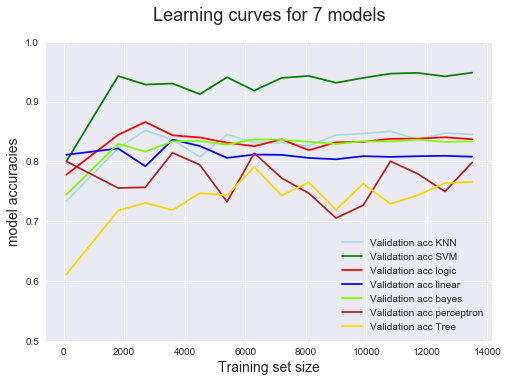

In [78]:
plt.style.use('seaborn')
# plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(data_size, val_knn, label = 'Validation acc KNN', color='#ADD8E6')
plt.plot(data_size, val_svm,  label = 'Validation acc SVM', color='g')
plt.plot(data_size, val_logic,  label = 'Validation acc logic', color='r')
plt.plot(data_size, val_linear,  label = 'Validation acc linear', color='b')
plt.plot(data_size, val_naive,  label = 'Validation acc bayes', color='#7CFC00')
plt.plot(data_size, val_perceptron,  label = 'Validation acc perceptron', color='#B22222')
plt.plot(data_size,  val_tree, label = 'Validation acc Tree', color='#FFD700')

plt.ylabel('model accuracies', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for 7 models', fontsize = 18, y = 1.05)
plt.legend()
plt.ylim(0.5, 1)

(0.6, 1.1)

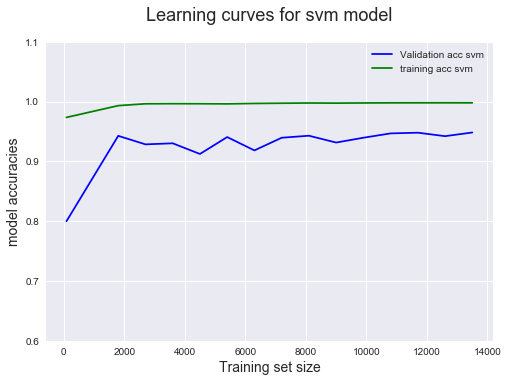

In [79]:
plt.style.use('seaborn')
# plt.plot(train_sizes, train_scores_mean, label = 'Training error')

plt.plot(data_size, val_svm,  label = 'Validation acc svm', color='b')
plt.plot(data_size,  train_svm, label = 'training acc svm', color='g')

plt.ylabel('model accuracies', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for svm model', fontsize = 18, y = 1.05)
plt.legend()
plt.ylim(0.6, 1.1)

(0.6, 1.1)

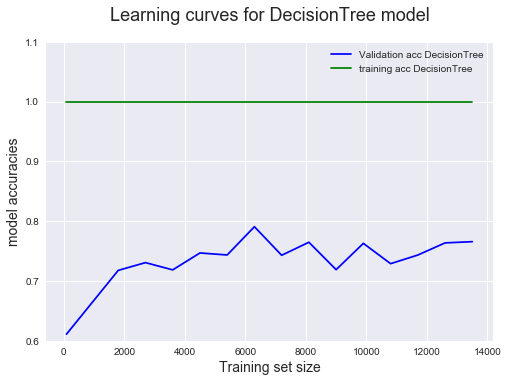

In [80]:
plt.style.use('seaborn')
# plt.plot(train_sizes, train_scores_mean, label = 'Training error')

plt.plot(data_size, val_tree,  label = 'Validation acc DecisionTree', color='b')
plt.plot(data_size,  train_tree, label = 'training acc DecisionTree', color='g')

plt.ylabel('model accuracies', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for DecisionTree model', fontsize = 18, y = 1.05)
plt.legend()
plt.ylim(0.6, 1.1)

(0.6, 1.1)

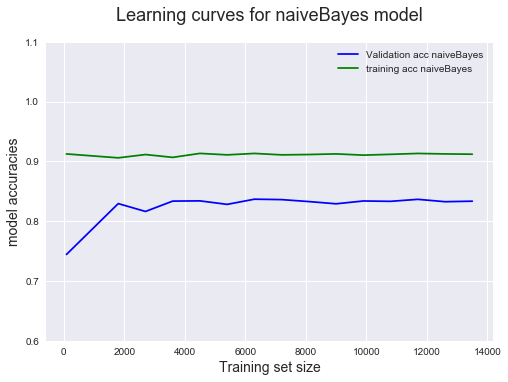

In [81]:
plt.style.use('seaborn')
# plt.plot(train_sizes, train_scores_mean, label = 'Training error')

plt.plot(data_size, val_naive,  label = 'Validation acc naiveBayes', color='b')
plt.plot(data_size,  train_naive, label = 'training acc naiveBayes', color='g')

plt.ylabel('model accuracies', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for naiveBayes model', fontsize = 18, y = 1.05)
plt.legend()
plt.ylim(0.6, 1.1)

(0.6, 1.1)

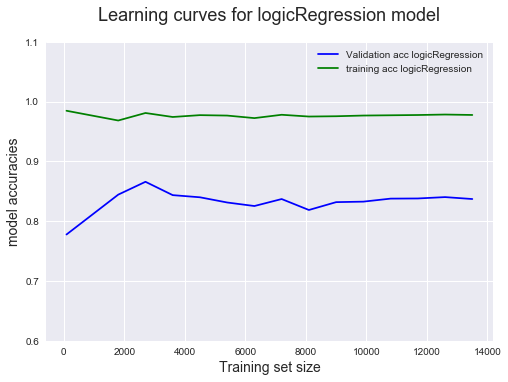

In [82]:
plt.style.use('seaborn')
# plt.plot(train_sizes, train_scores_mean, label = 'Training error')

plt.plot(data_size, val_logic,  label = 'Validation acc logicRegression', color='b')
plt.plot(data_size,  train_logic, label = 'training acc logicRegression', color='g')

plt.ylabel('model accuracies', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for logicRegression model', fontsize = 18, y = 1.05)
plt.legend()
plt.ylim(0.6, 1.1)

(13500, 14)


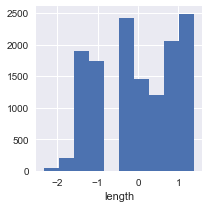

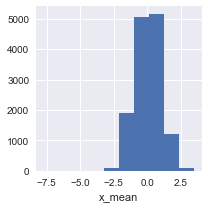

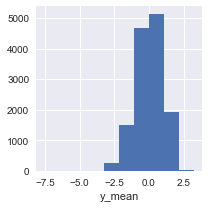

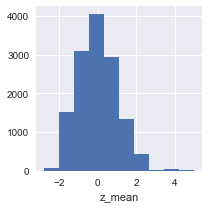

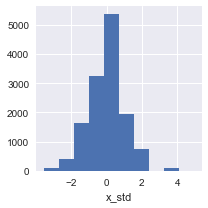

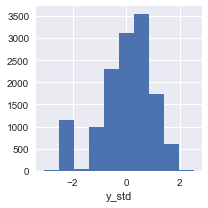

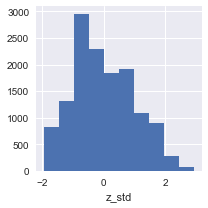

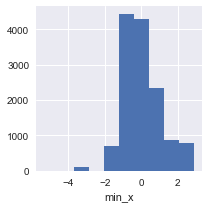

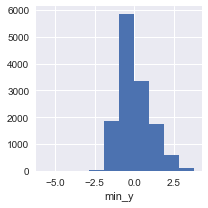

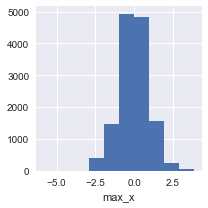

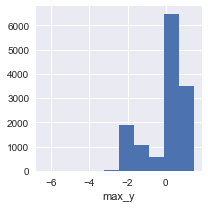

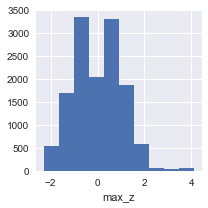

In [83]:
feature_array = np.array(features_data_points)
print(feature_array.shape)
feature_maps = feature_array[:,:13]
import seaborn as sns
import pandas as pd

 
df = pd.DataFrame(feature_maps, columns=['length','x_mean', 'y_mean', 'z_mean', 'x_std','y_std','z_std','min_x','min_y','min_z','max_x','max_y', 'max_z'])


g=sns.FacetGrid(df)
g.map(plt.hist,"length")

g=sns.FacetGrid(df)
g.map(plt.hist,"x_mean")

g=sns.FacetGrid(df)
g.map(plt.hist,"y_mean")

g=sns.FacetGrid(df)
g.map(plt.hist,"z_mean")

g=sns.FacetGrid(df)
g.map(plt.hist,"x_std")

g=sns.FacetGrid(df)
g.map(plt.hist,"y_std")

g=sns.FacetGrid(df)
g.map(plt.hist,"z_std")

g=sns.FacetGrid(df)
g.map(plt.hist,"min_x")

g=sns.FacetGrid(df)
g.map(plt.hist,"min_y")

g=sns.FacetGrid(df)
g.map(plt.hist,"max_x")

g=sns.FacetGrid(df)
g.map(plt.hist,"max_y")

g=sns.FacetGrid(df)
g.map(plt.hist,"max_z")
 

